# Visualization of the MNIST Dataset in 2D using t-SNE


In this notebook we use the t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm to visualize the MNIST images in 2D.

The t-SNE  is a Manifold Learning algorithm that reduces dimensionality while trying to **keep similar instances close and dissimilar instances apart**.

While Isomap, LLE and variants are best suited to unfold a single continuous low dimensional manifold, t-SNE focuses on the local structure of the data and tends to **extract clustered local groups of samples**. This ability to group samples based on the local structure might be beneficial to visually disentangle a dataset that comprises several manifolds at once as is the case in the **MNIST digits dataset**.


## Dataset: MNIST


We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 


## Goals

- Using the t-SNE we will visualize the MNIST dataset in 2D.

- Then, we will compare other linear (PCA, LDA) and non-linear (LLE, MDS, Isomap) methods of dimensionality reduction with t-SNE.

In [1]:
import warnings
import time
import numpy as np
import pandas as pd
from scipy.io import loadmat
import copy 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS, Isomap

## Load Data, Create Data Matrix (X) & Target Vector (y)

We may load the data from a local folder or load it directly from cloud using Scikit-Learn.

In [2]:
np.random.seed(42)

# Load data using Scikit-Learn
# mnist = fetch_openml('mnist_784', cache=False)

# X = mnist["data"].astype('float32')
# y = mnist["target"].astype('int64')

# Load the data from the local folder "data"
mnist = loadmat('/Users/hasan/datasets/MNIST/mnist-original.mat')

# Create the data Matrix X and the target vector y
X = mnist["data"].T.astype('float64')
y = mnist["label"][0].astype('int64')

print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Dimensionality Reduction using t-SNE

Dimensionality reduction using t-SNE on the full 70,000 images takes a very long time. 

Thus, we use a random subset of 10,000 images for projecting it onto 2D.

In [3]:
m = 10000
idx = np.random.permutation(70000)[:m]

X = X[idx]
y = y[idx]


print("\nReduced No. of Samples: ", X.shape)
print("Reduced No. of Labels: ", y.shape)


Reduced No. of Samples:  (10000, 784)
Reduced No. of Labels:  (10000,)


## Reduce Dimensionality to 2D

In [4]:
%%time

t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_tsne_reduced = tsne.fit_transform(X)
t1 = time.time()

duration_tsne = t1 - t0

print("The t-SNE takes {:.1f}s.".format(duration_tsne))
print("\n")

The t-SNE takes 227.4s.


CPU times: user 7min 8s, sys: 13.5 s, total: 7min 21s
Wall time: 3min 47s


## Plot the 2D Dataset

We use Matplotlib's scatter() function to plot a scatterplot, using a different color for each digit (0 = blue, 9 = dark red, etc.).

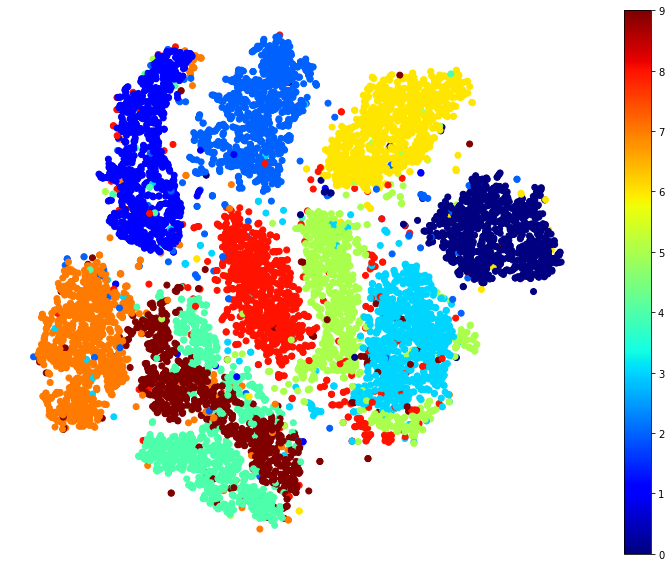

In [5]:
plt.figure(figsize=(13,10))
plt.scatter(X_tsne_reduced[:, 0], X_tsne_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## Observation:

This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often **hard to distinguish** (e.g., 4s and 9s, 5s and 3s, and so on).


## Zoom-in To a Subset of the Images

We may vizualize a subset of the image classes that has some overlapping.

Let's focus on digits 3, 4, 5 and 9. These numbers seem to overlap a lot.

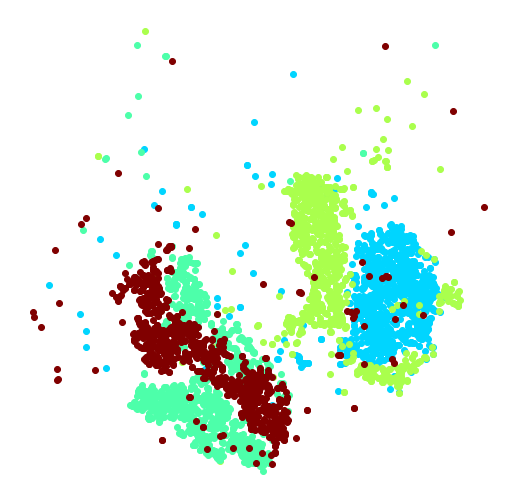

In [6]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")

for digit in (3, 5, 4, 9):
    plt.scatter(X_tsne_reduced[y == digit, 0], X_tsne_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

## Observation

We see that some 3s (blue points) and 9s (maroon points) have a wider spread. To better visualize their distributions we may apply t-SNE on just 4 digits (3, 4, 5 and 9).

## Apply t-SNE on a Subset of the Data

To produce a nicer image of a subset of the data (e.g., digits 3, 4, 5, and 9) we run t-SNE on these 4 digits.

In [7]:
%%time

idx = (y == 3) | (y == 4) | (y == 5) | (y == 9) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

CPU times: user 51.7 s, sys: 1.87 s, total: 53.6 s
Wall time: 51.9 s


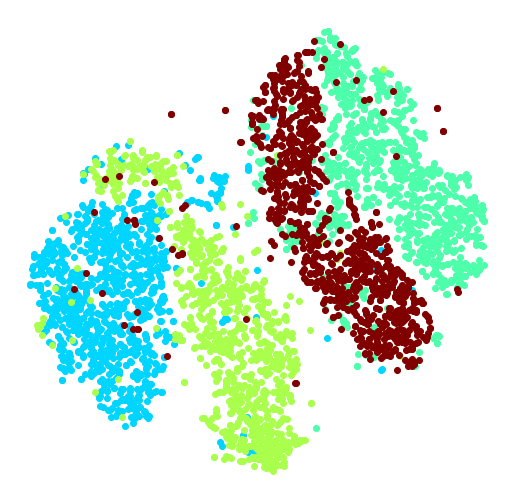

In [8]:
plt.figure(figsize=(9,9))
for digit in (3, 4, 5, 9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

## Observation

We see that some 3s (blue points) are all over the place. Plus, there are two distinct clusters of 3s, and also two distinct clusters of 4s. 

For a better understanding of the distribution of digits we could visualize a few digits from each cluster.

## Function to Write Colored Digits on a Scatterplot

We create a plot_digits() function that creates scatterplot using a different color for each digit and performs the followng two things.

- Write colored digits on the scatterplot, with a minimum distance guaranteed between these digits. 

- Plot digit images (if they are provided) on the scatterplot. 

In [9]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

## Write Colored Digits on the Scatterplot

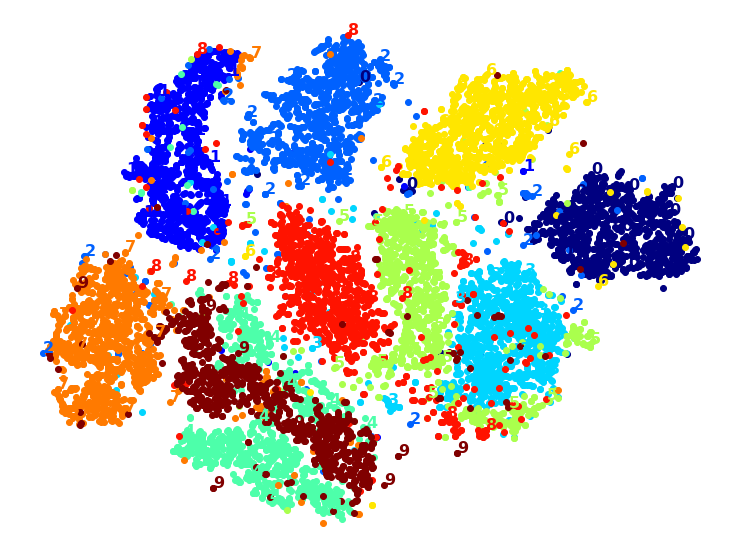

In [10]:
plot_digits(X_tsne_reduced, y)

## Plot Digit Images on the Scatterplot

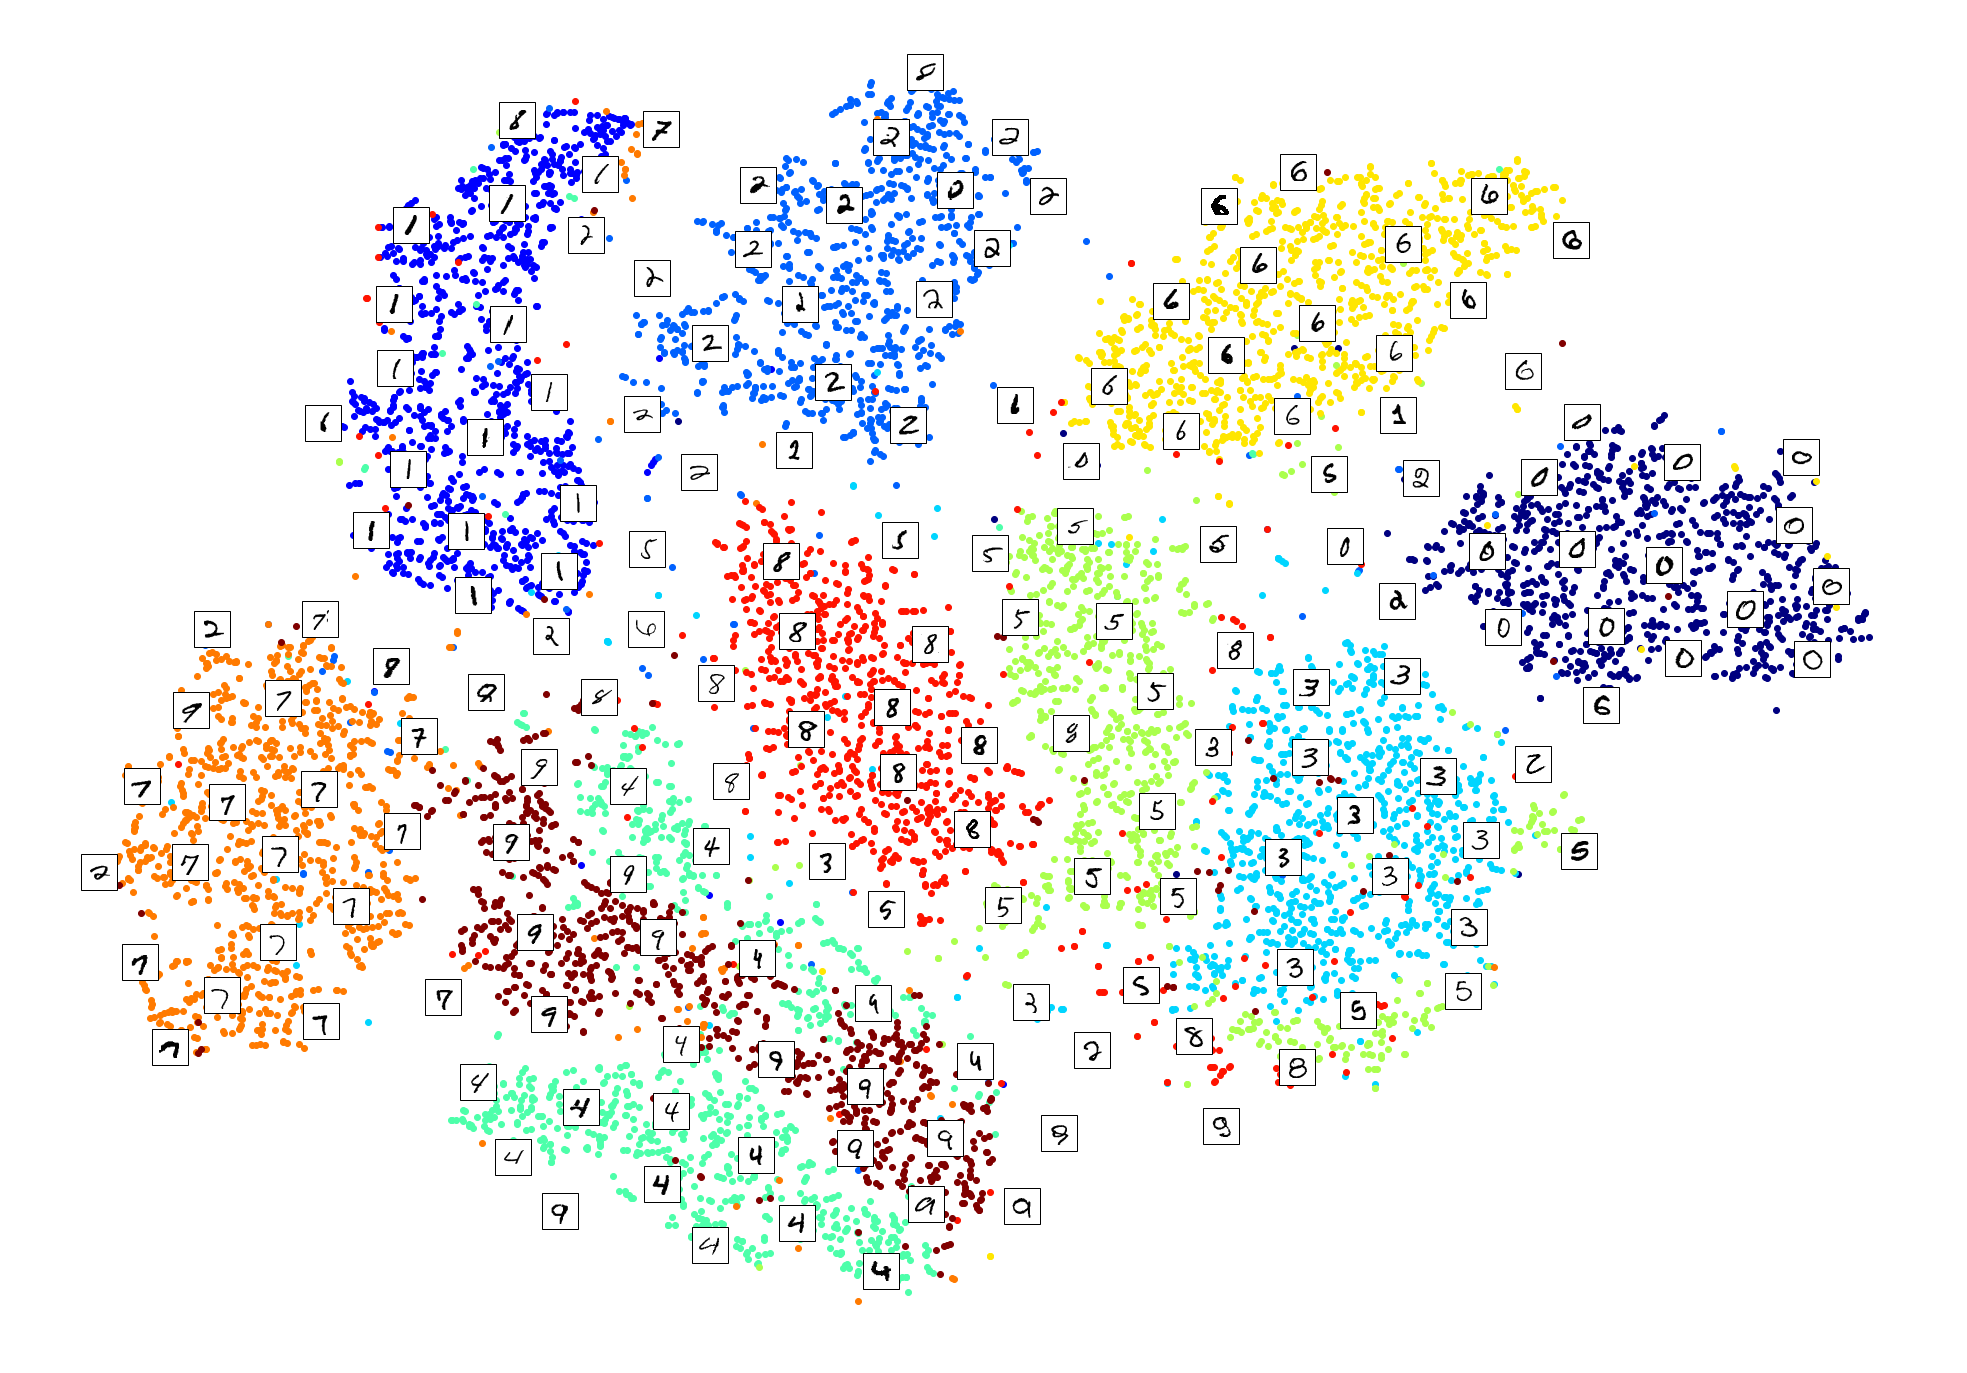

In [11]:
plot_digits(X_tsne_reduced, y, images=X, figsize=(35, 25))

## Plot the Digit Images for Digits 3, 4, 5 and 9 on the Scatterplot

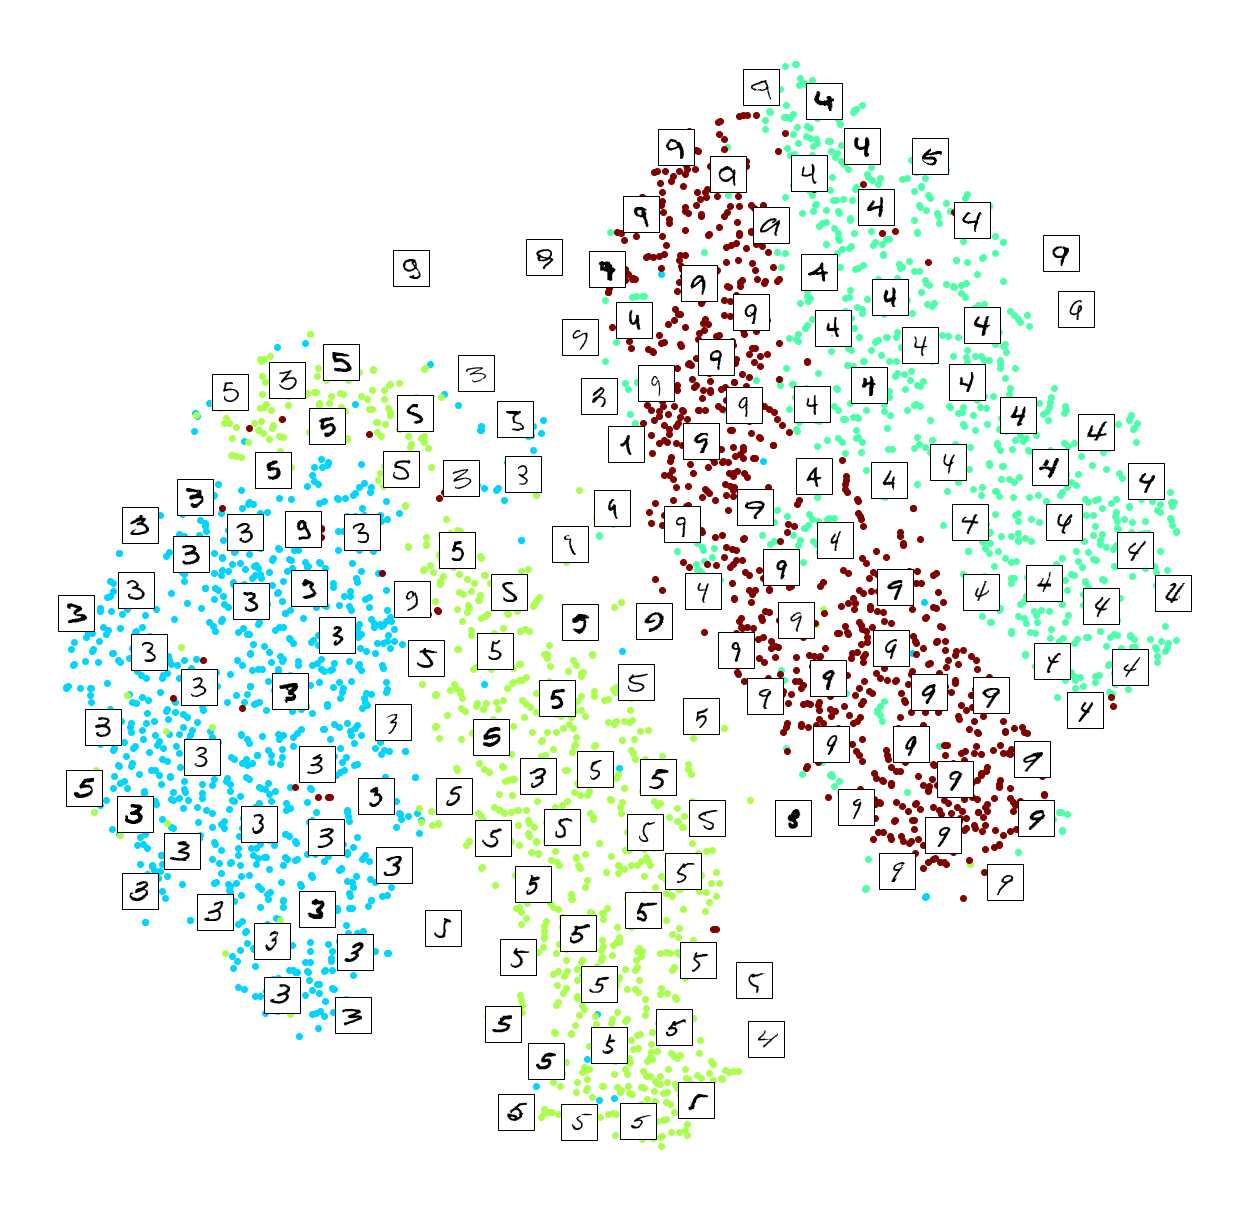

In [12]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

# Optimizing the Speed of t-SNE

We have observed that t-SNE is **very slow**.

To expedite the speed of dimensionality reduction using the t-SNE we may first apply PCA, followed by t-SNE.

The PCA + t-SNE takes 154.5s.


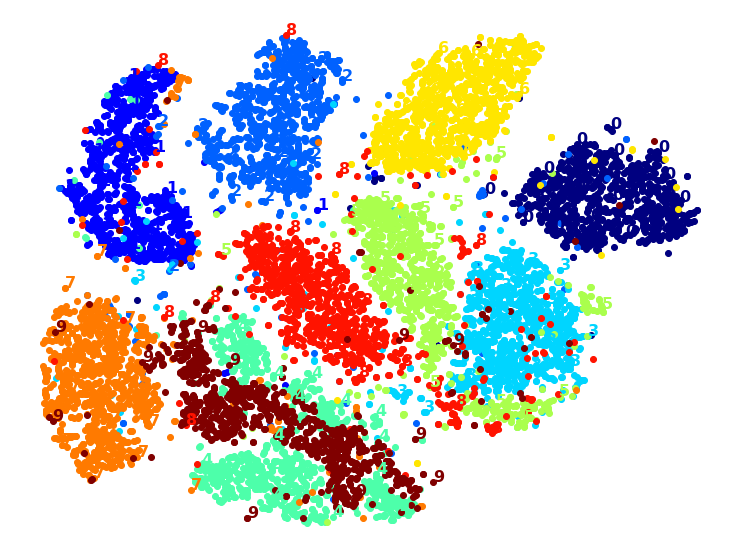

In [13]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()


duration_pca_tsne = t1 - t0
print("The PCA + t-SNE takes {:.1f}s.".format(duration_pca_tsne))

plot_digits(X_pca_tsne_reduced, y)
plt.show()

## Comparison of Running-Time between t-SNE and PCA+t-SNE

We observe that PCA+tSNE is **significantly faster** than just t-SNE.

In [14]:
data = [["t-SNE", duration_tsne], 
        ["PCA+t-SNE", duration_pca_tsne]]
pd.DataFrame(data, columns=["Algorithm", "Running-Time (s)"])

,Algorithm,Running-Time
0,t-SNE,227.436915
1,PCA+t-SNE,154.470777


# Comparison: LLE, MDS, Isomap, PCA and LDA

We compare the linear (PCA, LDA) and non-linear (LLE, MDS, Isomap) methods of dimensionality reduction with t-SNE by using these algorithms for visualizing the MNIST dataset in 2D.

Our goal is two-fold.
- Observe the quality of visualization
- Observe the running-time differences

In [15]:
# LLE
t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

duration_LLE = t1 - t0


# MDS
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

duration_MDS = t1 - t0

# Isomap
t0 = time.time()
X_isomap_reduced = Isomap(n_components=2).fit_transform(X)
t1 = time.time()

duration_Isomap = t1 - t0


# PCA
t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

duration_PCA = t1 - t0

# LDA
t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()

duration_LDA = t1 - t0


/Users/hasan/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Running Time of Various Dimensionality Reduction Techniques on MNIST Dataset

In [16]:
data = [["LLE", duration_LLE], 
        ["MDS", duration_MDS],
        ["Isomap", duration_Isomap],
        ["PCA", duration_PCA],
        ["LDA", duration_LDA]]
pd.DataFrame(data, columns=["Algorithm", "Running-Time (s)"])

,Algorithm,Running-Time
0,LLE,133.073244
1,MDS,4559.324644
2,Isomap,182.459089
3,PCA,0.176272
4,LDA,1.719760


## Visualization of MNIST Dataset in 2D by Various Dimensionality Reduction Techniques

We observe that only t-SNE is able to create meaningful visualization in 2D of the MNIST dataset.

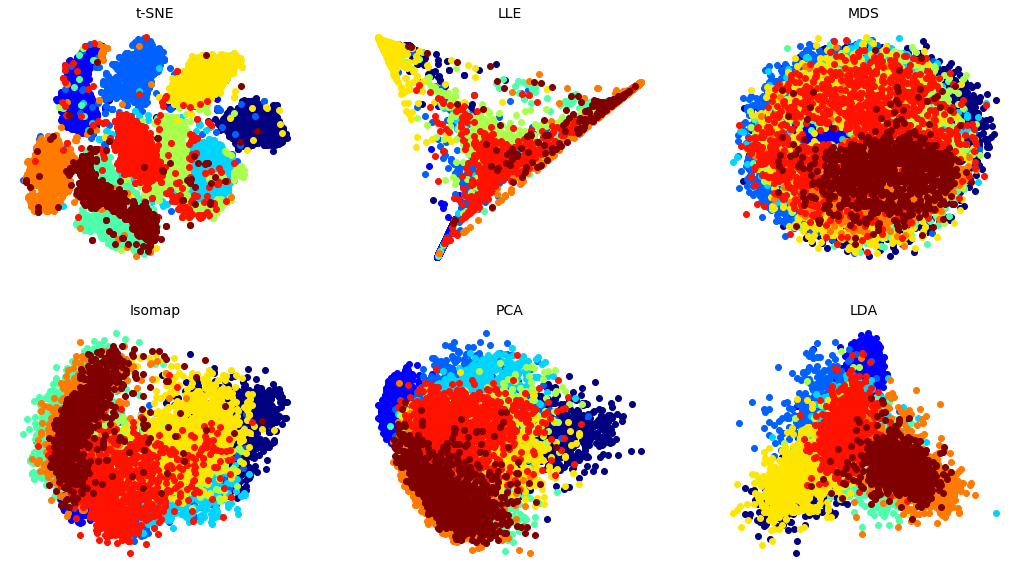

In [25]:
titles = ["t-SNE", "LLE", "MDS", "Isomap", "PCA", "LDA"]

plt.figure(figsize=(18,10))

for subplot, title, X_reduced in zip((231, 232, 233, 234, 235, 236), titles,
                                     (X_tsne_reduced, X_lle_reduced, X_mds_reduced, X_isomap_reduced,
                                     X_pca_reduced,X_lda_reduced)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
        
    X_normalized = MinMaxScaler().fit_transform(X_reduced)
    
    neighbors = np.array([[10., 10.]])
    digits = np.unique(y)
    cmap = mpl.cm.get_cmap("jet")
    
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
        plt.axis("off")
        ax = plt.gcf().gca()  # get current axes in current figure
        for index, image_coord in enumerate(X_normalized):
            closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
          
plt.show()